# rotate and rechunk velocity

### ! on datarmor: run at night or during weekends !

https://xgcm.readthedocs.io/en/latest/api.html#xgcm.Grid.interp_2d_vector

Use [rechunker](https://github.com/pangeo-data/rechunker), see [doc](https://rechunker.readthedocs.io/en/latest/)


In [1]:
import os, sys
from glob import glob
from shutil import rmtree
from tqdm import tqdm

import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xgcm
from rechunker import rechunk

import mitequinox.utils as ut
import mitequinox.sigp as sp
import mitequinox.plot as pl

In [2]:
from dask_jobqueue import PBSCluster
#
#cluster = PBSCluster(cores=2, processes=1, walltime='06:00:00')
#cluster = PBSCluster(cores=2, processes=1, walltime='01:00:00') # hal
#w = cluster.scale(jobs=10)
#
cluster = PBSCluster(cores=4, processes=4, walltime='03:00:00') # datarmor
w = cluster.scale(jobs=15)

#print(cluster.job_script())

# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: pars

In [3]:
cluster

---
# load standard lay out, rechunk and store right away

In [8]:
#ds = ut.load_data(["SSU", "SSV"])
ds = ut.load_data(["SSU", "SSV"], consolidated=False)
#ds = ds.isel(time=slice(0, 16*4)) # debug

grd = ut.load_grd() #.drop(['rA','rAw','rAs'])

#grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid = xgcm.Grid(grd, face_connections=ut.face_connections)

/home1/datahome/aponte/mit_equinox/mitequinox/utils.py:122: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(ref_data_dir + "grid.zarr", **kwargs)


In [9]:
def interp_rotate(ds):
    """ pack interpolation, rotation and rechunking in one method
    for custom_distribute
    """
    SSUV_interp = grid.interp_2d_vector({'X': ds.SSU, 'Y': ds.SSV}, boundary='fill')
    ds["SSU_rot"], ds["SSV_rot"] = ut.rotate(SSUV_interp["X"], SSUV_interp["Y"], grd)
    #SSU_rot, SSV_rot = ut.rotate(SSUV_interp["X"], SSUV_interp["Y"], grd)
    # minor rechunking to go in the right direction
    _ds = ds.drop(["SSU", "SSV"])
    #_ds = xr.merge([SSU_rot, SSV_rot ])
    #_ds = _ds.chunk(dict(i=-1,j=-1))
    #_ds = _ds.chunk(dict(time=4,i=4320//2,j=4320//2))
    _ds = _ds.chunk(dict(time=16,i=4320//4,j=4320//4))
    _ds = ut._reset_chunk_encoding(_ds)
    return _ds

In [10]:
zarr_main = os.path.join(ut.root_data_dir, "rechunked/SSUV_rotated.zarr")

ds_out, zarr = ut.custom_distribute(ds, 
                                    interp_rotate,
                                    suffix="SSUV_rotated.zarr",
                                    tmp_dir=os.path.join(ut.root_data_dir, "rechunked"),
                                    append=True,
                                    time=16*16,
                                   )

35it [05:58, 10.23s/it]


In [ ]:
cluster.close()

In [19]:
# dev: checks that all subset zarr archvies are good

# to cache output
# https://github.com/jupyterlab/jupyterlab/issues/2833#issuecomment-623845460

if False:

    Nf = len(glob(os.path.join(ut.scratch, "tmp/tmp_*")))
    zarrs = [os.path.join(ut.scratch, "tmp/tmp_{}".format(i)) for i in range(Nf)]

    # test on each zarr subset individually
    for z in zarrs[23:]:
        ds = xr.open_zarr(z)
        print(z)
        _ds = ds["SSU_rot"]
        print(_ds.shape)
        print(_ds.mean().values)
        _ds = ds["SSV_rot"]
        print(_ds.shape)
        print(_ds.mean().values)    

/home1/scratch/aponte/tmp/tmp_23
(256, 13, 4320, 4320)
0.025038147
(256, 13, 4320, 4320)
0.012390484
/home1/scratch/aponte/tmp/tmp_24
(256, 13, 4320, 4320)
0.02253124
(256, 13, 4320, 4320)
0.011698848
/home1/scratch/aponte/tmp/tmp_25
(256, 13, 4320, 4320)
0.02164226
(256, 13, 4320, 4320)
0.011040669
/home1/scratch/aponte/tmp/tmp_26
(256, 13, 4320, 4320)
0.015020202
(256, 13, 4320, 4320)
0.012384551
/home1/scratch/aponte/tmp/tmp_27
(256, 13, 4320, 4320)
0.01694937
(256, 13, 4320, 4320)
0.009415667
/home1/scratch/aponte/tmp/tmp_28
(256, 13, 4320, 4320)
0.017178439
(256, 13, 4320, 4320)
0.009473794
/home1/scratch/aponte/tmp/tmp_29
(256, 13, 4320, 4320)
0.01555624
(256, 13, 4320, 4320)
0.008157631
/home1/scratch/aponte/tmp/tmp_30
(256, 13, 4320, 4320)
0.020468231
(256, 13, 4320, 4320)
0.00809898
/home1/scratch/aponte/tmp/tmp_31
(256, 13, 4320, 4320)
0.01587301
(256, 13, 4320, 4320)
0.0067068445
/home1/scratch/aponte/tmp/tmp_32
(256, 13, 4320, 4320)
0.011301537
(256, 13, 4320, 4320)
0.00637

In [31]:
# dev: concatenates all zarr subsets into one manually
zarr_main = os.path.join(ut.root_data_dir, "rechunked/SSUV_rotated.zarr")
Nf = len(glob(os.path.join(ut.scratch, "tmp/tmp_*")))

for i in range(Nf):
    ds = xr.open_zarr(os.path.join(ut.scratch, "tmp/tmp_{}".format(i)))
    if i==0:
        ds.to_zarr(zarr_main, mode="w")
    else:
        ds.to_zarr(zarr_main, append_dim="time")

In [29]:
ds = xr.open_zarr(zarr_main)
ds

<xarray.Dataset>
Dimensions:  (face: 13, j: 4320, i: 4320, time: 9, i_g: 4320, j_g: 4320)
Coordinates: (12/13)
    CS       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    ...       ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(9,), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 ... 2011-12-06T10:00:00
Data variables:
    SSU_rot  (time, face, j, i) float32 dask.array<chunksize=(9, 1, 1080, 1080), meta=np.ndarray>
    SSV_rot  (time, face, j, i) float32 dask.array<chunksize=(9, 1, 1080, 1080), meta=np.ndarray>

In [ ]:
# dev: test for zarr appending
zarr = os.path.join(ut.scratch, "tmp/tmp_23")
ds = xr.open_zarr(zarr).isel(time=0)
#ds = xr.open_dataset(zarr, chunks={}, engine="zarr").isel(time=0)

zarr = os.path.join(ut.scratch, "tmp_zarr_append.zarr")

for face in range(3):
    #face=0
    #_ds = ds.sel(face=face)
    _ds = ds.sel(face=[face]).drop_vars(["time","face"])
    #_ds = _ds.SSU_rot.to_dataset()
    #_ds = ut._reset_chunk_encoding(_ds)
    if face==0:
        _ds.to_zarr(zarr, mode="w")
    else:
        _ds.to_zarr(zarr, mode="a", append_dim="face")
#_ds

### check data with snapshots

In [32]:
zarr = os.path.join(ut.root_data_dir, "rechunked/SSUV_rotated.zarr")
ds = xr.open_zarr(zarr)
ds = ds.isel(time=24*60, i=slice(0,None,8), j=slice(0,None,8)).persist()

(<Figure size 432x288 with 12 Axes>,
 array([[<AxesSubplot:xlabel='x-dimension of the t grid', ylabel='j'>,
         <AxesSubplot:xlabel='x-dimension of the t grid', ylabel='j'>,
         <AxesSubplot:xlabel='j', ylabel='x-dimension of the t grid'>,
         <AxesSubplot:xlabel='j', ylabel='x-dimension of the t grid'>],
        [<AxesSubplot:xlabel='x-dimension of the t grid', ylabel='j'>,
         <AxesSubplot:xlabel='x-dimension of the t grid', ylabel='j'>,
         <AxesSubplot:xlabel='j', ylabel='x-dimension of the t grid'>,
         <AxesSubplot:xlabel='j', ylabel='x-dimension of the t grid'>],
        [<AxesSubplot:xlabel='x-dimension of the t grid', ylabel='j'>,
         <AxesSubplot:xlabel='x-dimension of the t grid', ylabel='j'>,
         <AxesSubplot:xlabel='j', ylabel='x-dimension of the t grid'>,
         <AxesSubplot:xlabel='j', ylabel='x-dimension of the t grid'>]],
       dtype=object))

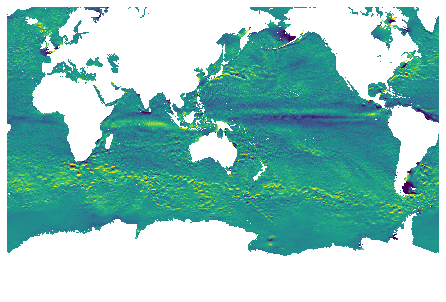

In [33]:
pl.quick_llc_plot(ds.SSU_rot, vmin=-1., vmax=1., 
               add_colorbar=False, axis_off=True)

(<Figure size 432x288 with 12 Axes>,
 array([[<AxesSubplot:xlabel='x-dimension of the t grid', ylabel='j'>,
         <AxesSubplot:xlabel='x-dimension of the t grid', ylabel='j'>,
         <AxesSubplot:xlabel='j', ylabel='x-dimension of the t grid'>,
         <AxesSubplot:xlabel='j', ylabel='x-dimension of the t grid'>],
        [<AxesSubplot:xlabel='x-dimension of the t grid', ylabel='j'>,
         <AxesSubplot:xlabel='x-dimension of the t grid', ylabel='j'>,
         <AxesSubplot:xlabel='j', ylabel='x-dimension of the t grid'>,
         <AxesSubplot:xlabel='j', ylabel='x-dimension of the t grid'>],
        [<AxesSubplot:xlabel='x-dimension of the t grid', ylabel='j'>,
         <AxesSubplot:xlabel='x-dimension of the t grid', ylabel='j'>,
         <AxesSubplot:xlabel='j', ylabel='x-dimension of the t grid'>,
         <AxesSubplot:xlabel='j', ylabel='x-dimension of the t grid'>]],
       dtype=object))

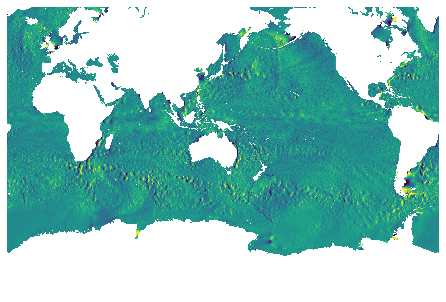

In [34]:
pl.quick_llc_plot(ds.SSV_rot, vmin=-1., vmax=1., 
               add_colorbar=False, axis_off=True)

In [ ]:
cluster.close()

--- 
## more severe rechunking

In [4]:
zarr = os.path.join(ut.root_data_dir, "rechunked/SSUV_rotated.zarr")
ds = xr.open_zarr(zarr)

In [5]:
# parameters for rechunking: time and space
#Nt0, Nc = 24*20, (288, 96) # file size ~ 
#Nt0, Nc = 24*160, (72, 48) # file size ~ 
#Nt0, Nc = 0, (72, 24) # file size ~ XMB files
chunks = (0, 72, 48) # file size ~ XMB files
chunks = (24*40, 288, 96) # file size ~ XMB files
#
#subsampling = 2
subsampling = 1

```
Source data size: 		 8640x13x4320x4320 	 8384.6GB
Source chunk size: 		 1x1x4320x4320		 74.6MB
Source number of files: 		 112320
Intermediate chunk size: 	 1x1x4320x4320		 74.6MB
Intermediate number of files: 		 112320
Target chunk size: 		 240x1x192x576 		 106.2MB
Target number of files: 		 78975
```

In [7]:
for v in tqdm(["SSU_rot", "SSV_rot"]):
    
    print(' --- '+v)

    #ds = ut.load_data(v)
    _ds = ds[v].to_dataset()
    del _ds["niter"]
    
    # cannot process all faces at the same time with the full grid
    #for face in ds.face:
    #    %time transpose_rechunk(ds, chunks, df['iter'], face=face, subsampling=subsampling, overwrite=False, max_mem='25GB')
    
    # but can with a subsampled grid (subsample=2)
    sp.transpose_rechunk(_ds, 
                         chunks, 
                         subsampling=subsampling, 
                         overwrite=True,
                         max_mem='25GB',
                         debug=False,
                        )
    
#  25%|██▌       | 1/4 [1:01:18<3:03:55, 3678.52s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 --- SSU_rot


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/worker.py:4149: UserWarning: Large object of size 6.75 MiB detected in task graph: 
  (<zarr.core.Array '/SSU_rot' (8640, 13, 4320, 4320 ... 39, 12, 3, 3)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
 50%|█████     | 1/2 [34:08<34:08, 2048.40s/it]

 rechunking over
 --- SSV_rot


100%|██████████| 2/2 [1:08:03<00:00, 2041.77s/it]

 rechunking over


In [ ]:
cluster.close()

In [50]:
if False:
    r=sp.transpose_rechunk(_ds, 
                             chunks, 
                             subsampling=subsampling, 
                             overwrite=True,
                             max_mem='25GB',
                             debug=True,
                            )
    sp.print_rechunk(r, v)

```
sp.print_rechunk(r, v)
sp.print_rechunk(r, v)
Source data size: 		 8640x13x4320x4320 	 8384.6GB
Source chunk size: 		 16x1x1080x1080		 74.6MB
Source number of files: 		 112320
Intermediate chunk size: 	 16x1x1080x1080		 74.6MB
Intermediate number of files: 		 112320
Target chunk size: 		 240x1x192x576 		 106.2MB
Target number of files: 		 78975
````

In [ ]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [17]:
ds = xr.open_zarr(os.path.join(ut.work_data_dir, "rechunked/"+V[0]+".zarr"))
ds

/dev/shm/pbs.7981975.datarmor0/ipykernel_1100/897255725.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(os.path.join(ut.work_data_dir, "rechunked/"+V[0]+".zarr"))


,Array,Chunk
Bytes,7.63 TiB,101.25 MiB
Shape,"(8640, 13, 4320, 4320)","(240, 1, 192, 576)"
Count,86113 Tasks,86112 Chunks
Type,float32,numpy.ndarray


---

## rechunk 1 face

In [6]:
face = 10 # done: 1, 7
chunks = (0, 144, 144) # file size ~ XMB files
subsampling = 1

In [7]:
#for v in tqdm(V):
for v in tqdm(["Eta"]):
    
    print(' --- '+v)

    ds = ut.load_data(v)
    
    # cannot process all faces at the same time with the full grid
    #for face in ds.face:
    #    %time transpose_rechunk(ds, chunks, df['iter'], face=face, subsampling=subsampling, overwrite=False, max_mem='25GB')
    
    # but can with a subsampled grid (subsample=2)
    sp.transpose_rechunk(ds, 
                         chunks, 
                         df['iter'], 
                         face=face,
                         subsampling=subsampling, 
                         overwrite=False, 
                         max_mem='25GB',
                        )

  0%|          | 0/1 [00:00<?, ?it/s]

 --- Eta
 face=10


100%|██████████| 1/1 [16:16<00:00, 976.46s/it]

 rechunking over


In [8]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 120.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


---

## dev

In [7]:
out_dir = work_data_dir+'rechunked/'  # /work/ALT/swot/aval/syn/rechunked/
#out_dir = '/work/scratch/pontea/' # 2TB max
overwrite = True

v = V[0]
print(v)

ds = load_data(v)

# select common time line
t0 = ds['time'].where(ds.iters==df['iter'][0],drop=True).values[0]
t1 = ds['time'].where(ds.iters==df['iter'][-1],drop=True).values[0]
ds = ds.sel(time=slice(t0,t1))

ds['dtime'] = ds['dtime'].compute()
ds['iters'] = ds['iters'].compute()

face=1
ds = ds.isel(face=face)

Nt = len(ds.time)-1 if Nt0 == 0 else Nt0
# -1 is to obtain 8784 which you can divide by 4**2

# necessary ?
ds = ds.isel(time=slice(len(ds.time)//Nt *Nt))

SSU


In [15]:
d = get_chunks((Nt,)+Nc, v, 0)

{'time': 8784, 'face': 1, 'i_g': 72, 'j': 24}
Individual chunk size = 60.7 MB


In [16]:
get_chunks((Nt,)+Nc, v, 1)

{'time': 2196, 'face': 1, 'i_g': 144, 'j': 48}
Individual chunk size = 60.7 MB


{'SSU': {'time': 2196, 'face': 1, 'i_g': 144, 'j': 48},
 'time': None,
 'face': None,
 'i_g': None,
 'j': None,
 'dtime': (-1,),
 'iters': (-1,)}

In [17]:
get_chunks((Nt,)+Nc, v, 2)

{'time': 549, 'face': 1, 'i_g': 288, 'j': 96}
Individual chunk size = 60.7 MB


{'SSU': {'time': 549, 'face': 1, 'i_g': 288, 'j': 96},
 'time': None,
 'face': None,
 'i_g': None,
 'j': None,
 'dtime': (-1,),
 'iters': (-1,)}

In [19]:
# rechunker parameters
max_mem = '30GB'
target_store = out_dir+v+'.zarr'
temp_store = out_dir+v+'-tmp.zarr'

# clean archives if necessary
if os.path.isdir(target_store):
    if overwrite:
        rmtree(target_store)
    else:
        assert False, 'Archive exists and you do not want to overwrite'
rmtree(temp_store, ignore_errors=True)

# init rechunker
target_chunks = get_chunks((Nt,)+Nc, v, 1)
r = rechunk(ds, target_chunks, max_mem, target_store, temp_store=temp_store)

### 1 pass:
# 100GB: (1, 648, 4320) # 5MB file size 
# 50GB: (1, 312, 4320) # 5MB file size 
# 20GB: (1, 120, 4320)
# 10GB: (1, 48, 4320)
# 1GB: (1, 24, 1152)

### 2 pass - step 1:
# 40GB: (1, 1008, 4320) # 14MB file size
# 30GB: (1, 768, 4320) # 11MB file size

#r._intermediate['SSU'].info
print_rechunk(r, v)

{'time': 2196, 'face': 1, 'i_g': 144, 'j': 48}
Individual chunk size = 60.7 MB
Source data size: 		 8784x4320x4320 	 655.7GB
Source chunk size: 		 1x4320x4320 		 74.6MB
Source number of files: 		 8784
Intermediate chunk size: 	 1x768x4320 		 13.3MB
Intermediate number of files: 		 49410
Target chunk size: 		 2196x48x144 		 60.7MB
Target number of files: 		 10800


Full transposition

```
{'time': 8784, 'face': 1, 'i_g': 72, 'j': 24}
Individual chunk size = 15.2 MB
Source data size: 		 8784x4320x4320 	 655.7GB
Source chunk size: 		 1x4320x4320 		 74.6MB
Source number of files: 		 	 8784
Intermediate chunk size: 	 1x192x4320 		 3.3MB
Intermediate number of files: 		 197640
Target chunk size: 		 8784x24x72 		 60.7MB
Target number of files: 		 	 10800
```

Fractional transposition

```
{'time': 2196, 'face': 1, 'i_g': 144, 'j': 48}
Individual chunk size = 15.2 MB
Source data size: 		 8784x4320x4320 	 655.7GB
Source chunk size: 		 1x4320x4320 		 74.6MB
Source number of files: 			 8784
Intermediate chunk size: 	 1x768x4320 		 13.3MB
Intermediate number of files: 		 49410
Target chunk size: 		 2196x48x144 		 60.7MB
Target number of files: 			 10800
```

In [20]:
%time result = r.execute()

CPU times: user 2min 40s, sys: 7.77 s, total: 2min 48s
Wall time: 20min 50s


In [45]:
result['SSU'].info

Name,/SSU
Type,zarr.core.Array
Data type,float32
Shape,"(8784, 4320, 4320)"
Chunk shape,"(2196, 48, 144)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,655722086400 (610.7G)
No. bytes stored,430851069618 (401.3G)


In [33]:
target_store

'/work/scratch/pontea//SSU.zarr'

In [32]:
ds_out = xr.open_zarr(target_store)
ds_out

<xarray.Dataset>
Dimensions:  (i_g: 4320, j: 4320, time: 8785)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<chunksize=(8785,), meta=np.ndarray>
    face     int64 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    iters    (time) int64 dask.array<chunksize=(8785,), meta=np.ndarray>
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.732e+07 3.732e+07
Data variables:
    SSU      (time, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [35]:
import zarr

In [38]:
#ds_out = xr.open_zarr(temp_store)
zarr_out = zarr.open(temp_store)
print(zarr_out.tree())

/
 └── SSU (8785, 4320, 4320) float32


In [40]:
zarr_out['SSU'].info

Name,/SSU
Type,zarr.core.Array
Data type,float32
Shape,"(8785, 4320, 4320)"
Chunk shape,"(1, 4320, 4320)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,655796736000 (610.8G)
No. bytes stored,431429548615 (401.8G)


In [ ]:
# loop around variables

for v in V:
    
    out_dir = work_data_dir+'rechunked/'  # /work/ALT/swot/aval/syn/rechunked/
    #out_dir = '/work/scratch/pontea/' # 2TB max
    overwrite = True

    print(' --- '+v)

    ds = load_data(v)

    # select common time line
    t0 = ds['time'].where(ds.iters==df['iter'][0],drop=True).values[0]
    t1 = ds['time'].where(ds.iters==df['iter'][-1],drop=True).values[0]
    ds = ds.sel(time=slice(t0,t1))

    ds['dtime'] = ds['dtime'].compute()
    ds['iters'] = ds['iters'].compute()

    face=1
    ds = ds.isel(face=face)

    Nt = len(ds.time)-1 if Nt0 == 0 else Nt0
    # -1 is to obtain 8784 which you can divide by 4**2

    # necessary ?
    ds = ds.isel(time=slice(len(ds.time)//Nt *Nt))
    
    # rechunker parameters
    max_mem = '30GB'
    target_store = out_dir+v+'_f{:02d}.zarr'.format(face)
    temp_store = out_dir+'tmp.zarr'

    # clean archives if necessary
    if os.path.isdir(target_store):
        if overwrite:
            rmtree(target_store)
        else:
            assert False, 'Archive exists and you do not want to overwrite'
    rmtree(temp_store, ignore_errors=True)

    # init rechunker
    target_chunks = get_chunks((Nt,)+Nc, v, 1)
    r = rechunk(ds, target_chunks, max_mem, target_store, temp_store=temp_store)    
    
    print_rechunk(r, v)
    
    # exec
    %time result = r.execute()
    
    # clean up intermediate file
    rmtree(temp_store, ignore_errors=True)
    

---

In [33]:
client.restart()

Client Scheduler: tcp://10.135.39.21:38424 Dashboard: /user/pontea/proxy/40997/status,Cluster Workers: 4 Cores: 8 Memory: 400.00 GB


In [8]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 120.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
